In [59]:
import pandas as pd
import os
import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
from shapely.geometry import Point
import folium
import rasterio
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import STL
from arch.unitroot import PhillipsPerron
import numpy as np
from sklearn.linear_model import LinearRegression
import datetime as dt
from matplotlib.colors import TwoSlopeNorm
import time

In [60]:
#Load Data
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires\\Classification_Fires')
fire_data_classified = pd.read_csv('fires_data_classified.csv', index_col=0)
#Select only the agricultural fires
fire_data = fire_data_classified[fire_data_classified['agricultural'] == 1]

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\geospatial_internship\\datasets')
telangana_shape = gpd.read_file('telangana_shapefile.geojson')

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires\\DPPD_Jesse')
one_km_grid = gpd.read_file('telangana_10km_grid.geojson')

#Create geodataframe from the data
geo_fire_data = gpd.GeoDataFrame(fire_data,geometry = gpd.points_from_xy(fire_data.longitude,fire_data.latitude), crs = {'init': 'epsg:4326'}) 

#Make sure the geometry columns are in the right format
geo_fire_data['geometry'] = geo_fire_data['geometry'].geometry.to_crs(epsg = 4326)
one_km_grid['geometry'] = one_km_grid['geometry'].geometry.to_crs(epsg = 4326)

#Load date into date format
geo_fire_data['acq_date'] =  pd.to_datetime(geo_fire_data['acq_date'])
geo_fire_data['year'] = (geo_fire_data['acq_date']).dt.year
geo_fire_data['month'] = (geo_fire_data['acq_date']).dt.month
geo_fire_data['day'] = (geo_fire_data['acq_date']).dt.day

#Select complete years (2015-2020)
geo_fire_data = geo_fire_data[(geo_fire_data['acq_date'] >= '2015-01-01') & (geo_fire_data['acq_date'] < '2021-01-1')]

c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [61]:
fires_per_grid= gpd.sjoin(geo_fire_data, one_km_grid, how="inner", op='intersects')

#Create the right time format: we count per month per year
fires_per_grid['day'] = 1 #pd.Series(pd.to_numeric(fires_per_mandal['day'], errors='coerce'), dtype='int64')
fires_per_grid['year'] = pd.Series(pd.to_numeric(fires_per_grid['year'], errors='coerce'), dtype='int64')
fires_per_grid['month'] = pd.Series(pd.to_numeric(fires_per_grid['month'], errors='coerce'), dtype='int64')
fires_per_grid['ModifiedDateTime'] = pd.to_datetime(fires_per_grid[['year', 'month', 'day']].astype('int64').astype('str'), yearfirst=True)

#Sort the values based on mandal and time
fires_per_grid_count = fires_per_grid.sort_values(by=['ModifiedDateTime'])

#Sum amount of fires per mandal per month per year make sure that if no fire happens at a specific time write a zero
fires_per_grid_count = fires_per_grid.groupby(['id', 'ModifiedDateTime'])['fireID'].count().unstack(fill_value=0).stack().reset_index()

fires_per_grid_count['Amount of Fires'] = fires_per_grid_count[0] #/ round(fires_per_mandal_count['Crops']/1000000)

#Delete column
del fires_per_grid_count[0]

#For standardizing the amount of fires regarding crop area in a mandal
#fires_per_grid_count = fires_per_grid_count.merge(one_km_grid[['id', 'geometry']], how='left', on=['geometry'])

#Select the column we are interested in standardized or non-standardized
fires_per_grid_count['Fires'] = fires_per_grid_count['Amount of Fires'] 

fires_per_grid_count['ModifiedDateTime'] =  pd.to_datetime(fires_per_grid_count['ModifiedDateTime'])

<ipython-input-61-2f4f434497b2>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  fires_per_grid= gpd.sjoin(geo_fire_data, one_km_grid, how="inner", op='intersects')


In [64]:
def Trend_Grid(df, id): 
    grid = df[df['id'] == id] 
    grid = grid.sort_values(by=['ModifiedDateTime'])
    grid.index = grid['ModifiedDateTime']

    if not grid.empty:

        X = grid['Fires']
        #result = adfuller(X)
        #ADF_p_value = result[1]

        #kpsstest = kpss(X, regression='c', nlags="auto")
        #kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
        #kpss_p_value = kpss_output[1]

        #php_ct = PhillipsPerron(X)
        #pp_p_value = float(php_ct.summary().as_text().split()[8])

        #Decompose using STL Seasonal-Trend Decomposition using LOESS
        stl = STL(grid['Fires'], seasonal=7)
        res = stl.fit()
        #res.plot()

        #Moving Averages
        #result_year = seasonal_decompose(mandal['Fires'], model='additive')

        df_trend = res.trend.to_frame().reset_index().dropna()
        df_trend['ModifiedDateTime_num'] = df_trend['ModifiedDateTime'].map(dt.datetime.toordinal)

        X = np.array(df_trend['ModifiedDateTime_num'])
        X = X.reshape(-1, 1)
        y = np.array(df_trend['trend'])
        y = y.reshape(-1, 1)
        reg = LinearRegression().fit(X, y)

        y_pred_trend = reg.predict(X)

        slope, intercept = np.polyfit(np.array(df_trend['ModifiedDateTime_num']), y_pred_trend,1)

        regression_score = reg.score(X, y)
        line_slope = slope[0]

    else:
        line_slope = 'Unknown'
        regression_score = 'Unknown' 
        #ADF_p_value = 'Unknown'
        #kpss_p_value = 'Unknown' 
        #pp_p_value = 'Unknown'

    return(line_slope, regression_score)

In [65]:
fires_per_grid_count.head()

,id,ModifiedDateTime,Amount of Fires,Fires
0,278,2015-01-01,0,0
1,278,2015-02-01,0,0
2,278,2015-03-01,0,0
3,278,2015-04-01,0,0
4,278,2015-05-01,0,0


In [66]:
Trend_Grid(fires_per_grid_count, 278)

(6.18714930576858e-05, 0.08331067116990132)

In [67]:
#DPPD Scores: The negativer the number, we observe a higher decrease in fires over the years
#The completely white mandals are the mandals in which no agricultural fires are observed
st = time.time()
ids= []
scores = []
accuracies = []
#adf_scores = []
#kpss_scores = []
#pp_scores = []
for i in range(0, len(one_km_grid['id'])):
    if i%25000==0:
        print(str(i) + ' iterations in ' +  str((time.time()-st)/60) , ' minutes')
    ids.append(one_km_grid['id'].iloc[i])
    score, accuracy = Trend_Grid(fires_per_grid_count, fires_per_grid_count['id'].iloc[i])
    scores.append(score)
    accuracies.append(accuracy)
    #adf_scores.append(adf)
    #kpss_scores.append(kpss_)
    #pp_scores.append(pp)

DPPD_df = pd.DataFrame({'id': ids, 'Slope Score': scores, 'Regression Score': accuracies}) # 'Augmented Dickey Fuller Test': adf_scores, 'Kpss Test': kpss_scores, 'PhillipsPerron': pp_scores})

0 iterations in 0.013102734088897705  minutes


In [68]:
DPPD_df = DPPD_df[DPPD_df['Slope Score'] != 'Unknown']
DPPD_df = DPPD_df.sort_values('Slope Score')
DPPD_df = DPPD_df.merge(one_km_grid[['id', 'geometry']], how='left', on=['id'])
DPPD_df = gpd.GeoDataFrame(DPPD_df, geometry = DPPD_df.geometry, crs = {'init': 'epsg:4326'}) 
DPPD_df.to_file('C:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires\\DPPD_Jesse\\DPPD_df_grid_10.geojson', driver="GeoJSON")  



c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


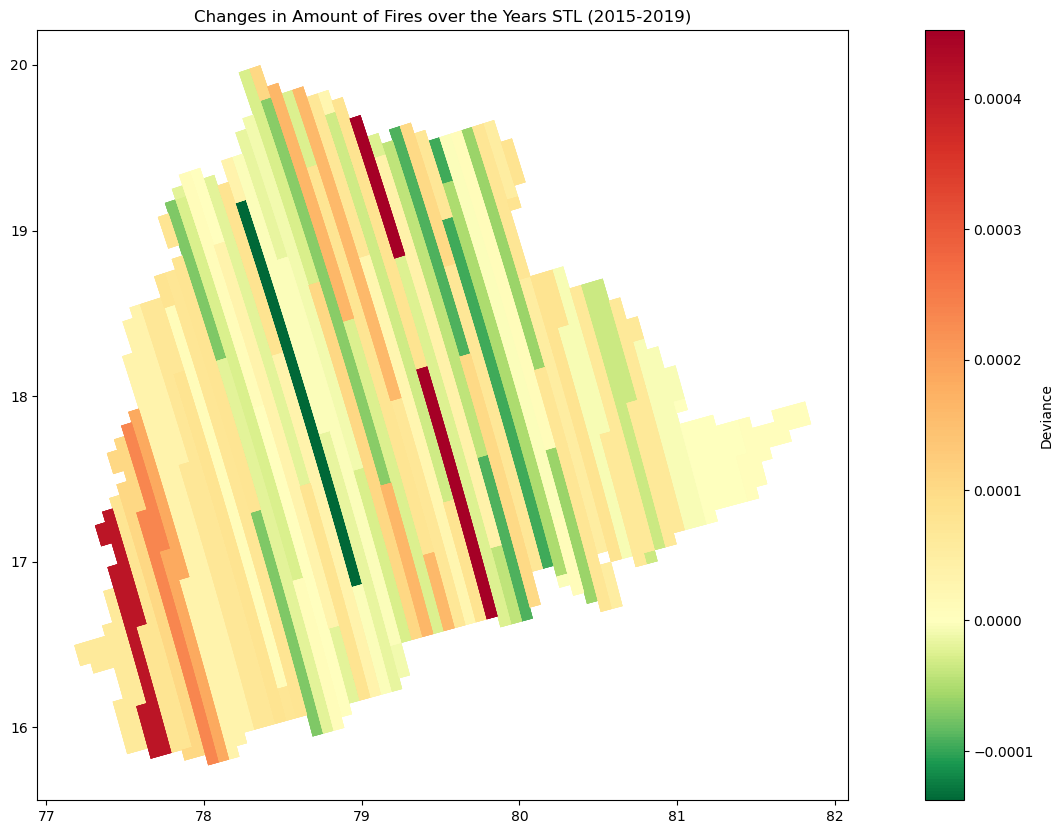

In [69]:
vmin, vmax, vcenter = DPPD_df['Slope Score'].min(), DPPD_df['Slope Score'].max(), 0
norm = TwoSlopeNorm(vmin= vmin , vcenter=vcenter, vmax= vmax) #-0.00150 #0.00060
# create a normalized colorbar
cmap = 'RdYlGn_r'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
DPPD_df.plot(column = 'Slope Score', 
                      legend = True, 
                      figsize = [20,10],\
                      legend_kwds = {'label': 'Deviance'}, 
                      cmap = 'RdYlGn_r',
                      norm = norm)
plt.title('Changes in Amount of Fires over the Years STL (2015-2019)')
plt.savefig('Changes in Amount of Fires over the Years 10 Grid STL (2015-2019).png')
plt.show()
